In [2]:
# works
import tensorflow as tf

# 1. List all physical GPU devices.
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) > 3:  # Ensure you have at least 4 GPUs.
    # 2. Use only GPU 2 and GPU 3.
    tf.config.experimental.set_visible_devices([ gpus[2], gpus[3]], 'GPU')

    # 3. Set memory growth for GPU 1 and GPU 2.
    for gpu in [ gpus[2],  gpus[3]]:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Not enough GPUs. Make sure you have at least 4 GPUs.")
strategy = tf.distribute.MirroredStrategy()  
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [ ]:
#!pip install imagecodecs


**This notebook runs U-Net on the train data and make a prediction on extracted 12 region**
**Part 1. Import libraries and define functions and models**

In [1]:
# imports
import cv2
import os
import math                 
import numpy as np
import rasterio
import rasterio.plot
from rasterio.windows import Window   
from rasterio.warp import reproject, Resampling     
import scipy.io as sio       
import matplotlib as plt     
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import netcdf as nc      
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import datetime
from tensorflow.keras.models import save_model
from skimage.transform import resize
from tensorflow.keras.callbacks import LambdaCallback
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.transform import resize
import rasterio
from rasterio.plot import show
from shapely.geometry import box
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, regularizers
import geopandas as gpd
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, Point
import re
from tifffile import imread

**Model**

In [4]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
    if regularization is not None:
        kernel_regularizer = l2(regularization)
    else:
        kernel_regularizer = None
        
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(x)

    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def Unet(IMAGE_DIMS, n_filters=16, dropout=0.25, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
   
    input_img = Input(IMAGE_DIMS, name='img')

    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, regularization=regularization,
                      kernel_initializer=kernel_initializer)
    p1 = MaxPooling2D((2, 2)) (c1)
    if dropout !=  None:
        p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    if dropout !=  None:
        p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    if dropout !=  None:
        p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    if dropout !=  None:
        p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    if dropout !=  None:
        u6 = Dropout(dropout)(u6)
    
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    if dropout !=  None:
        u7 = Dropout(dropout)(u7)
    
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    if dropout !=  None:
        u8 = Dropout(dropout)(u8)
    
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    if dropout !=  None:
        u9 = Dropout(dropout)(u9)
    
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
 
    return model

In [10]:
import os
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score_Loss(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   
    return 1. - score

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


**Define different pixel-based metrics for binary semantic segmentation.**

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size, img_dims, mask_dims):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.mask_dims = mask_dims
        self.indexes = np.arange(len(self.img_paths))
        

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_img_paths = self.img_paths[start:end]
        batch_mask_paths = self.mask_paths[start:end]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]
        batch_masks = [self._load_mask(mask_path) for mask_path in batch_mask_paths]

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = resize(image, self.img_dims, mode='constant', preserve_range=True)
        return image / 255.0

    def _load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, self.mask_dims, mode='constant', preserve_range=True, order=0)
        mask = mask.astype(np.float32)
        return np.expand_dims(mask, axis=-1)


**Attention: If you download the saved model(best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5) and test_tiles_no_overlap from Google Drive, You can skip the below steps until Part 3.** 

**This part is for training data with the train set. The saved model is used to make predictions on the test set.**

**Define data generator to read images and masks in batches.**

In [6]:
from skimage.transform import resize

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size, img_dims, mask_dims):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.mask_dims = mask_dims
        self.indexes = np.arange(len(self.img_paths))

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]  # Use the shuffled/arranged indexes
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]
        batch_masks = [self._load_mask(mask_path) for mask_path in batch_mask_paths]

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = resize(image, self.img_dims, mode='constant', preserve_range=True)
        return image / 255.0

    def _load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, self.mask_dims, mode='constant', preserve_range=True, order=0)
        mask = mask.astype(np.float32)
        #return np.expand_dims(mask, axis=-1)
        return mask


In [7]:

def read_files(input_dir,target_dir):

    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".tif")
        ]
    )
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".tif") and not fname.startswith(".")
        ]
    )

    #print("Number of samples:", len(input_img_paths))
   # print("Number of samples:", len(target_img_paths))
    for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
        
      #  print(input_path, "|", target_path)
       return input_img_paths, target_img_paths



**Part 2: Model Training**

**(Note: This section does not need to be executed. The finalized models have already been saved and can be found in the "submission 3" folder on Google Drive which is shared with  Committee. These models will be used for predictions on the 12 test images.)**



**Attention: First, the model is trained on the 2,000 images, and their masks contain the mask labels. The acquired weight will be saved to train the whole train dataset. Their folders are available for download in Google Drive. (The process of generating these folders is available in the preprocessing step notebook.)**

**Attention: The order of running the two below cells is reversed. Please first run cell 2 and then cell 1.**

Use the saved weight of the model trained on 2,000 images to train the model with the whole data set. The below patch must be set. The process of making tiled folders is available on the preprocessing notebook.

model.load_weights('best_model_lake_512_512_2k_UNet_fold_2.h5').
input_dir = "train_tiles"   
target_dir = "mask_tiles"

The below models' weight is saved to make predictions on the final test set.


In [47]:
# run this cell next. Please first run the next cell!
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
input_dir = "train_tiles"   
target_dir = "mask_tiles"

input_img_paths, target_img_paths = read_files(input_dir, target_dir)
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=42)


import random
num_folds = 2
batch_size = 48
history_list = []
epochs = 120

import os

kf = KFold(n_splits=num_folds, shuffle=False, random_state=0)

combined = list(zip(input_img_paths, target_img_paths))
random.shuffle(combined)
input_img_paths[:], target_img_paths[:] = zip(*combined)

train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_img_paths)):  # Notice the change here
    print(f'Fold {fold + 1}')

    # Split the data into train and validation sets for this fold
    train_images, val_images = np.array(train_img_paths)[train_index], np.array(train_img_paths)[val_index]  # Convert list to np.array
    train_masks, val_masks = np.array(train_mask_paths)[train_index], np.array(train_mask_paths)[val_index]  # Convert list to np.array


    img_dims = (512, 512,3)
    mask_dims = (512, 512,1)
    train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    val_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    test_generator = DataGenerator(test_img_paths, test_mask_paths, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
            
            
            model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=0.01, kernel_initializer="he_normal")
            model.load_weights('best_model_lake_512_512_2k_UNet_fold_0.h5')

            

            binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
            # Compile the model
            model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=dice_loss,
                        metrics=[binary_iou, dice_coef, F1_score])

    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_lake_512_512_20k_UNet_fold_{fold}.h5', monitor='val_dice_coef',mode='max', save_best_only=True, verbose=1)
   # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=1e-6, patience=10, verbose=1, mode='min')
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

    save_model(model, f'complete_model_lake_512_512_20k_UNet_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_lake_512_512_20k_UNet_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_generator)
    val_scores = model.evaluate(val_generator)
    test_scores = model.evaluate(test_generator)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coelfficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:04:28
Fold 1


/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Epoch 1/120
167/167 [==============================] - ETA: 0s - loss: 0.4490 - binary_iou: 0.7607 - dice_coef: 0.5560 - F1_score: 0.5362
Epoch 1: val_dice_coef improved from -inf to 0.42916, saving model to best_model_lake_512_512_20k_UNet_fold_0.h5
167/167 [==============================] - 512s 3s/step - loss: 0.4490 - binary_iou: 0.7607 - dice_coef: 0.5560 - F1_score: 0.5362 - val_loss: 0.5790 - val_binary_iou: 0.6345 - val_dice_coef: 0.4292 - val_F1_score: 0.2838
Epoch 2/120
167/167 [==============================] - ETA: 0s - loss: 0.3954 - binary_iou: 0.7682 - dice_coef: 0.6134 - F1_score: 0.5497
Epoch 2: val_dice_coef did not improve from 0.42916
167/167 [==============================] - 503s 3s/step - loss: 0.3954 - binary_iou: 0.7682 - dice_coef: 0.6134 - F1_score: 0.5497 - val_loss: 0.6350 - val_binary_iou: 0.6937 - val_dice_coef: 0.3733 - val_F1_score: 0.3716
Epoch 3/120
167/167 [==============================] - ETA: 0s - loss: 0.3898 - binary_iou: 0.7748 - dice_coef: 0.6

**Attention, first run the below cell, then the previous cell**

The below cell's saved weight (best_model_lake_512_512_2k_UNet_fold.h5) is used in the previous cell to train the model on the entire train set. the below folders are available on Google Drive. Also, the code for generating them is available on preprocessing notebook.

In [80]:
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
input_dir = "filtered_train_tiles"   
target_dir = "filtered_mask_tiles"

input_img_paths, target_img_paths = read_files(input_dir, target_dir)
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=42)


import random
num_folds = 3
batch_size = 18
history_list = []
epochs = 200

import os

kf = KFold(n_splits=num_folds, shuffle=False, random_state=0)
#print("Train Image Paths:", train_img_paths[:5])  # Print the first 5 paths for brevity
#print("Train Mask Paths:",  train_mask_paths[:5])  # Print the first 5 paths for brevity


#images, masks = shuffle(input_img_paths,target_img_paths, random_state=0)
combined = list(zip(input_img_paths, target_img_paths))
random.shuffle(combined)
input_img_paths[:], target_img_paths[:] = zip(*combined)

#for _ in range(5):
  #  idx = random.randint(0, len(input_img_paths)-1)
    #print(input_img_paths[idx])
    #print(target_img_paths[idx])
#plot_image_mask(input_img_paths[0], target_img_paths[0])
#plot_image_mask(input_img_paths[2], target_img_paths[2])
#plot_image_mask(input_img_paths[10], target_img_paths[10])
#plot_image_mask(input_img_paths[20], target_img_paths[20])
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_img_paths)):  # Notice the change here
    print(f'Fold {fold + 1}')

    # Split the data into train and validation sets for this fold
    train_images, val_images = np.array(train_img_paths)[train_index], np.array(train_img_paths)[val_index]  # Convert list to np.array
    train_masks, val_masks = np.array(train_mask_paths)[train_index], np.array(train_mask_paths)[val_index]  # Convert list to np.array


    img_dims = (512, 512,3)
    mask_dims = (512, 512,1)
    train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    
    val_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    test_generator = DataGenerator(test_img_paths, test_mask_paths, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
            
            
            model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=0.01, kernel_initializer="he_normal")
            

            binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
            # Compile the model
            model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=dice_loss,
                        metrics=[binary_iou, dice_coef, F1_score])

    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_lake_512_512_2k_UNet_fold_{fold}.h5', monitor='val_dice_coef',mode='max', save_best_only=True, verbose=1)
   # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=1e-6, patience=10, verbose=1, mode='min')
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[early_stop, checkpoint],
                        verbose=0)

    save_model(model, f'complete_model_lake_512_512_2k_UNet_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_lake_512_512_2k_UNet_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_generator)
    val_scores = model.evaluate(val_generator)
    test_scores = model.evaluate(test_generator)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 05:36:15
Fold 1

Epoch 1: val_dice_coef improved from -inf to 0.04878, saving model to best_model_lake_512_512_2k_UNet_fold_0.h5

Epoch 2: val_dice_coef did not improve from 0.04878

Epoch 3: val_dice_coef did not improve from 0.04878

Epoch 4: val_dice_coef did not improve from 0.04878

Epoch 5: val_dice_coef improved from 0.04878 to 0.18159, saving model to best_model_lake_512_512_2k_UNet_fold_0.h5

Epoch 6: val_dice_coef did not improve from 0.18159

Epoch 7: val_dice_coef improved from 0.18159 to 0.47453, saving model to best_model_lake_512_512_2k_UNet_fold_0.h5

Epoch 8: val_dice_coef did not improve from 0.47453

Epoch 9: val_dice_coef improved from 0.47453 to 0.69653, saving model to best_model_lake_512_512_2k_UNet_fold_0.h5

Epoch 10: val_dice_coef did not improve from 0.69653

Epoch 11: val_dice_coef did not improve from 0.69653

Epoch 12: val_dice_coef improved from 0.69653 to 0.70162, saving model to best_model_lake_512_512_2k_UNet_fold_0.h5

Epoch 13: val_dic

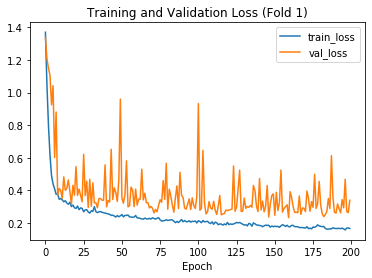

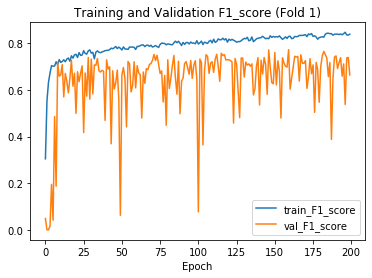

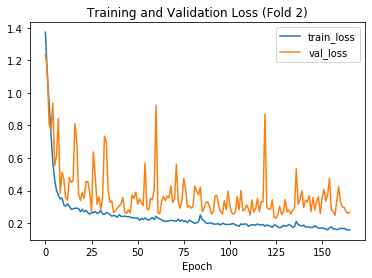

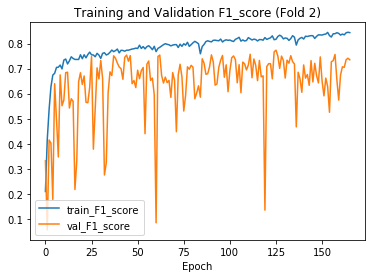

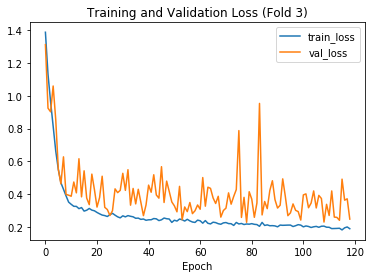

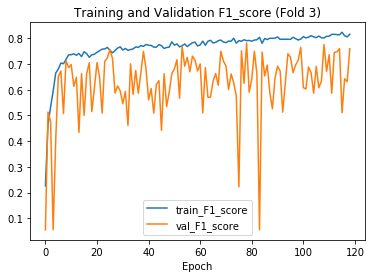

In [92]:
for fold in range(num_folds):
   
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
 
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
 
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

**Attention: If you download the saved model(best_model_lake_512_512_2k_UNet_fold_2.h5) and test_tiles_no_overlap from Google Drive, You can skip the above step until here.**



**Part 3. Make a prediction on the final test set (12 test images). Define data generator.**

The below contains a data generator for reading the tiled test images to make a prediction.

(There are 4 images containing 12 regions. All the test regions are divided into tiles of 512,512 to be used for prediction with the model trained on 512,512 image dimensions). The patch of the tiled test files must be set in the below code, like:

test_image_directory='test_tiles_no_overlap'

The code for generating the 'test_tiles_no_overlap' folder is available in preprocessing notebook. The generated folder is available on the Google Drive.



In [5]:
# First: set the path of tiled test image
test_image_directory='test_tiles_no_overlap'
test_image_paths = [os.path.join(test_image_directory, filename) for filename in os.listdir(test_image_directory) if filename.endswith('.tif')]
batch_size = 12

In [6]:
# Second, read test images with data generator
import os
import cv2
import numpy as np
import tensorflow as tf
from skimage.transform import resize

class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, batch_size):
        self.img_paths = img_paths
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.img_paths))

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]

        # Filter out None values (invalid images)
        batch_images = [img for img in batch_images if img is not None]
        batch_img_paths = [img_path for img_path, img in zip(batch_img_paths, batch_images)]

        return np.array(batch_images), batch_img_paths

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise Exception(f"Error loading image: {img_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize the image to the expected shape ( 512, 512,3)
            image = cv2.resize(image, (512, 512))

            # Normalize the pixel values to the range [0, 1]
            image = image / 255.0

            return image
        except Exception as e:
            print(f"Error loading image: {img_path} - {str(e)}")
            return None

# Define TestDataGenerator class above

# Initialize the TestDataGenerator with test image paths
test_data_generator = TestDataGenerator(img_paths=test_image_paths, batch_size=batch_size)

**Predict the final test set (tiled 12 large test images)**

The model, which is trained with the train data, must be added to the below code. Like the below line:

model.load_weights("best_model_lake_512_512_2k_UNet_fold_2.h5")

The tiled test images must be added in the below cell:
test_image_directory = 'test_tiles_no_overlap'

Set Paths for saving predicted images and original test images in the below cell

output_folder_predicted = "Final_Predictions/predicted_test_U_Net_no_overlap"

output_folder_original = "Final_Predictions/original_test_U_Net_no_overlap"

In [7]:
import os

# Define the folder path
output_folder_predicted = "Final_Predictions/predicted_test_U_Net_no_overlap"

# Check if the folder already exists, if not, create it
if not os.path.exists(output_folder_predicted):
    os.makedirs(output_folder_predicted)

# Define the folder path
output_folder_original = "Final_Predictions/original_test_U_Net_no_overlap"

# Check if the folder already exists, if not, create it
if not os.path.exists(output_folder_original):
    os.makedirs(output_folder_original )    

In [ ]:
# 3. Make prediction on final test set (tile with the 0- padding- with no overlap)

import os
import cv2
import numpy as np
import shutil
import tensorflow as tf

IMAGE_DIMS = (512, 512, 3)
model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=0.01, kernel_initializer="he_normal")

# Load the model weights from the .h5 file
model.load_weights("best_model_lake_512_512_2k_UNet_fold_2.h5")

# Compile the model and specify the custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=dice_loss,
    metrics=[binary_iou, dice_coef, F1_score] 
)

# Initialize the TestDataGenerator with test image paths
test_image_directory = 'test_tiles_no_overlap'

# List all image files in the directory
test_image_paths = [os.path.join(test_image_directory, filename) for filename in os.listdir(test_image_directory) if filename.endswith('.tif')]
batch_size = 12  # Adjust as needed
test_data_generator = TestDataGenerator(test_image_paths, batch_size)

# Initialize lists to store predictions and original image paths
all_predictions = []
all_original_paths = []

# 5. Loop through the DataGenerator, make predictions, and save the results.
for batch_images, batch_img_paths in test_data_generator:
    if batch_images is not None:
        # Filter out invalid images (None elements)
        valid_indices = [i for i, img in enumerate(batch_images) if img is not None]
        valid_batch_images = [batch_images[i] for i in valid_indices]
        valid_batch_img_paths = [batch_img_paths[i] for i in valid_indices]

        if valid_batch_images:
            # Make predictions for valid images
            predictions = model.predict(np.array(valid_batch_images))  # Ensure numpy array

            # Save predicted images with their original names
            for i, img_path in enumerate(valid_batch_img_paths):
                img_name = os.path.basename(img_path)
                img_name_without_extension, _ = os.path.splitext(img_name)
                output_path = os.path.join(output_folder_predicted, img_name_without_extension + ".tif")

                # Save the predicted image (ensure it's in the correct format)
                # Save the predicted image as a single-channel grayscale image
                cv2.imwrite(output_path, predictions[i].astype(np.uint8) * 255, [cv2.IMWRITE_PNG_COMPRESSION, 0])


                # Copy the original test image to the "original" folder
                original_output_path = os.path.join(output_folder_original, img_name)
                shutil.copy2(img_path, original_output_path)

                # Append predictions and original image paths to lists
                all_predictions.append(predictions[i])
                all_original_paths.append(original_output_path)
        else:
            print("No valid images in the batch. Skipping...")
    else:
        print("Error loading batch of images. Skipping...")

# Convert the lists to NumPy arrays for further processing if needed
all_predictions = np.array(all_predictions)
all_original_paths = np.array(all_original_paths)

# Now we have the predictions and original image paths for further analysis

Sanity check: samples of predictions on the tiled test set

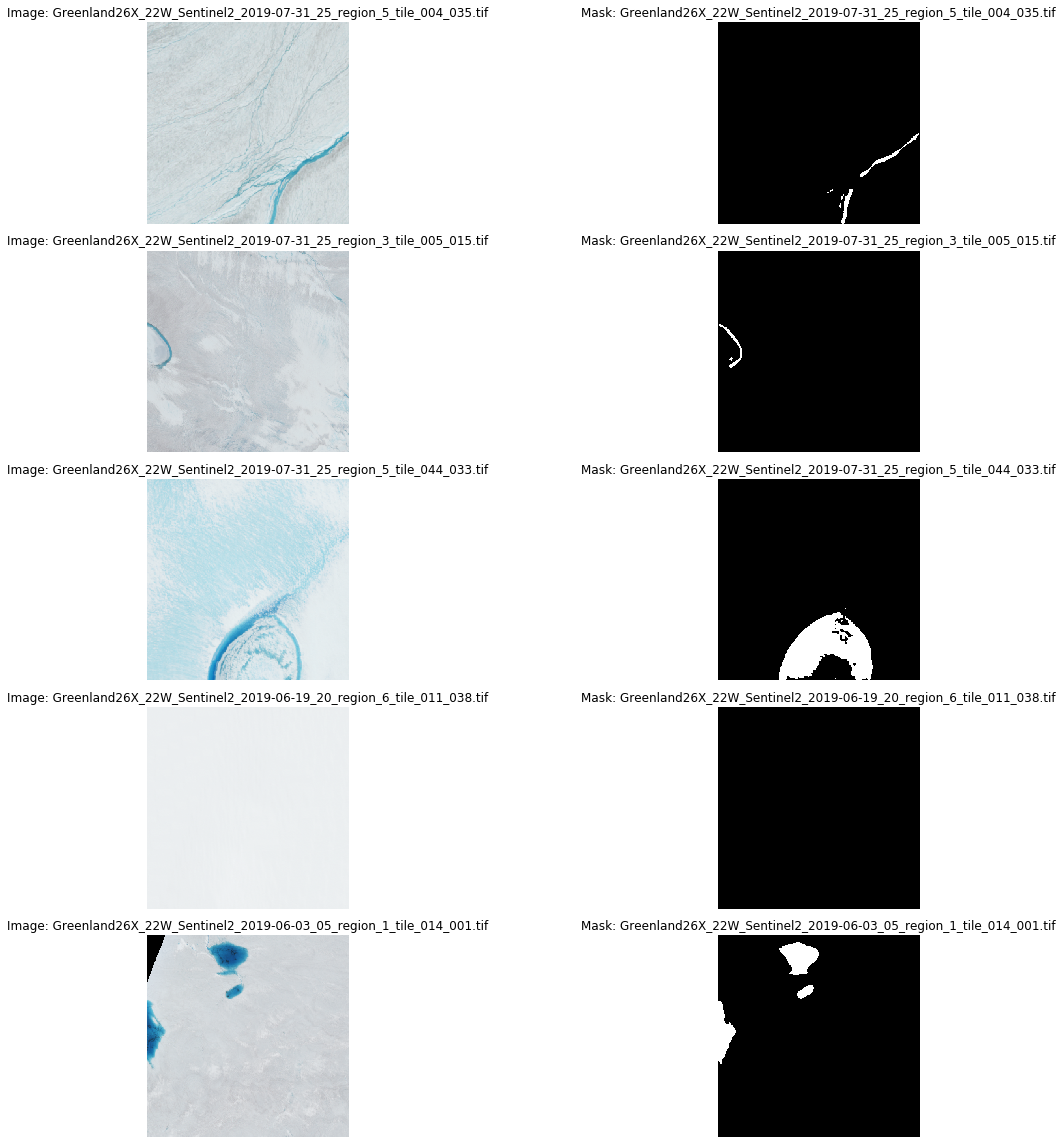

In [9]:
import os
import random
import matplotlib.pyplot as plt
from tifffile import imread  # For reading .tif files

# Define the image and mask directories
image_folder = 'Final_Predictions/original_test_U_Net_no_overlap'
predicted_folder = 'Final_Predictions/predicted_test_U_Net_no_overlap'

# Get all image filenames
all_images = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Randomly select 5 images
selected_images = random.sample(all_images, 5)

# Plot the selected images and their corresponding masks
fig, axes = plt.subplots(5, 2, figsize=(16 ,16))  # 5 rows, 2 columns

for i, image_name in enumerate(selected_images):
    # Read image and its corresponding mask
    image_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(predicted_folder, image_name)
    
    image = imread(image_path)
    mask = imread(mask_path)
    
    # Plot image and mask
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {image_name}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask: {image_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

End part 3

Part 4. Stitch the tiled test images and the predicted images with the dimensions of 512, 512 to have 12 regions' predictions with their original sizes.

We must set the path to the JSON folder, which contains each image's information of added 0 padding positions in each image. (The JSON folder is available on Google Drive)

We must set the paths in the code below to stitch predicted images together:

input_folder = "test_tiles_no_overlap"

output_folder = "stitched_tiled_test_images_submission_3"

metadata_folder = "json_test_tiles_no_overlap"

In [10]:
# It works correctly, stitching the tiled test images to rebuild the 12 images
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import json

def stitch_tiles(input_folder, output_folder, metadata_folder):
    for root, _, files in os.walk(metadata_folder):
        for metadata_file in files:
            if metadata_file.endswith("_metadata.json"):
                metadata_path = os.path.join(root, metadata_file)
                with open(metadata_path, 'r') as json_file:
                    metadata = json.load(json_file)

                # Determine the dimensions of the stitched image based on the metadata
                max_x = max(
                    tile_info["x_offset"] + tile_info["width"]  # Include padding in width
                    for tile_info in metadata
                )
                max_y = max(
                    tile_info["y_offset"] + tile_info["height"]  # Include padding in height
                    for tile_info in metadata
                )

                min_x = min(tile_info["x_offset"] for tile_info in metadata)
                min_y = min(tile_info["y_offset"] for tile_info in metadata)

                stitched_width = max_x - min_x
                stitched_height = max_y - min_y

                stitched_image = np.zeros((stitched_height, stitched_width), dtype=np.uint8)

                for tile_info in metadata:
                    tile_path = os.path.join(input_folder, tile_info["tile_name"])

                    x_start = tile_info["x_offset"]
                    y_start = tile_info["y_offset"]
                    tile_width = tile_info["width"]
                    tile_height = tile_info["height"]
                    padding_x, padding_y = tile_info["padding"]

                    # Calculate the coordinates for adding the tile to the stitched image
                    x_stitched_start = x_start - min_x
                    y_stitched_start = y_start - min_y
                    x_stitched_end = x_stitched_start + tile_width
                    y_stitched_end = y_stitched_start + tile_height

                    # Read the tile data
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read(1)

                    # Crop the tile data to exclude padding
                    tile_data = tile_data[padding_y:padding_y+tile_height, padding_x:padding_x+tile_width]

                    # Calculate the corresponding coordinates in the stitched image
                    x_stitched_coords = slice(x_stitched_start, x_stitched_end)
                    y_stitched_coords = slice(y_stitched_start, y_stitched_end)

                    # Add the tile data to the stitched image
                    stitched_image[y_stitched_coords, x_stitched_coords] = tile_data

                # Save the stitched image
                output_image_path = os.path.join(output_folder, metadata_file.replace("_metadata.json", ".tif"))
                with rasterio.open(output_image_path, 'w', driver='GTiff', width=stitched_width, height=stitched_height, count=1, dtype=np.uint8) as dst:
                    dst.write(stitched_image, 1)

# Define input and output directories
input_folder = "test_tiles_no_overlap"
output_folder = "stitched_tiled_test_images_submission_3"
metadata_folder = "json_test_tiles_no_overlap"

# Ensure output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Stitch the predicted tiles
stitch_tiles(input_folder, output_folder, metadata_folder)

/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


**Stitching the tiled predicted images to rebuild the 12 predicted images**

input_folder = "Final_Predictions/predicted_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"

output_folder = "stitched_test_prediction_submission_3"

metadata_folder = "json_test_tiles_no_overlap"

In [11]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import json

def stitch_binary_prediction_tiles(input_folder, output_folder, metadata_folder):
    for root, _, files in os.walk(metadata_folder):
        for metadata_file in files:
            if metadata_file.endswith("_metadata.json"):
                metadata_path = os.path.join(root, metadata_file)
                with open(metadata_path, 'r') as json_file:
                    metadata = json.load(json_file)

                # Determine the dimensions of the stitched image based on the metadata
                max_x = max(
                    tile_info["x_offset"] + tile_info["width"]  # Include padding in width
                    for tile_info in metadata
                )
                max_y = max(
                    tile_info["y_offset"] + tile_info["height"]  # Include padding in height
                    for tile_info in metadata
                )

                min_x = min(tile_info["x_offset"] for tile_info in metadata)
                min_y = min(tile_info["y_offset"] for tile_info in metadata)

                stitched_width = max_x - min_x
                stitched_height = max_y - min_y

                stitched_image = np.zeros((stitched_height, stitched_width), dtype=np.uint8)

                for tile_info in metadata:
                    tile_path = os.path.join(input_folder, tile_info["tile_name"])

                    x_start = tile_info["x_offset"]
                    y_start = tile_info["y_offset"]
                    tile_width = tile_info["width"]
                    tile_height = tile_info["height"]
                    padding_x, padding_y = tile_info["padding"]

                    # Calculate the coordinates for adding the tile to the stitched image
                    x_stitched_start = x_start - min_x
                    y_stitched_start = y_start - min_y
                    x_stitched_end = x_stitched_start + tile_width
                    y_stitched_end = y_stitched_start + tile_height

                    # Read the tile data
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read(1)

                    # Crop the tile data to exclude padding
                    tile_data = tile_data[padding_y:padding_y+tile_height, padding_x:padding_x+tile_width]

                    # Calculate the corresponding coordinates in the stitched image
                    x_stitched_coords = slice(x_stitched_start, x_stitched_end)
                    y_stitched_coords = slice(y_stitched_start, y_stitched_end)

                    # Add the tile data to the stitched image
                    stitched_image[y_stitched_coords, x_stitched_coords] = tile_data

                # Save the stitched image as a single-band (one channel) binary image
                output_image_path = os.path.join(output_folder, metadata_file.replace("_metadata.json", ".tif"))
                with rasterio.open(output_image_path, 'w', driver='GTiff', width=stitched_width, height=stitched_height, count=1, dtype=np.uint8) as dst:
                    dst.write(stitched_image, 1)

# Define input and output directories
input_folder = 'Final_Predictions/predicted_test_U_Net_no_overlap'
output_folder = "stitched_test_prediction_submission_3"
metadata_folder = "json_test_tiles_no_overlap"

# Ensure output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Stitch the binary prediction tiles
stitch_binary_prediction_tiles(input_folder, output_folder, metadata_folder)

/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


**End Part 4**

**Below cells are sanity check**

**there is no need to run them**

Start of sanity checks

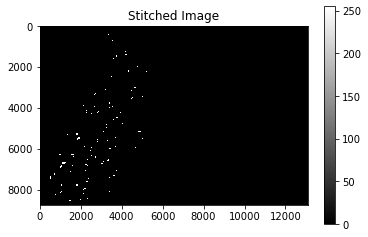

In [12]:
import matplotlib.pyplot as plt
import rasterio

def plot_stitched_image(stitched_image_path):
    with rasterio.open(stitched_image_path) as src:
        # Read the stitched image data
        image = src.read(1)  # Assuming a single band image, adjust if multi-band

        # Plot the image with the 'gray' colormap
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.title("Stitched Image")
        plt.show()
stitched_image_path = "stitched_test_prediction_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
plot_stitched_image(stitched_image_path)

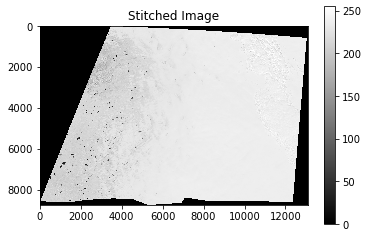

In [14]:
import matplotlib.pyplot as plt
import rasterio

def plot_stitched_image(stitched_image_path):
    with rasterio.open(stitched_image_path) as src:
        # Read the stitched image data
        image = src.read(1)
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.title("Stitched Image")
        plt.show()
stitched_image_path = "stitched_tiled_test_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
plot_stitched_image(stitched_image_path)

In [15]:
import rasterio

with rasterio.open(stitched_image_path) as src:
    image = src.read(1)  # Assuming a single band image, adjust if multi-band
    print("Data Type:", image.dtype)
    print("Min Value:", image.min())
    print("Max Value:", image.max())

Data Type: uint8
Min Value: 0
Max Value: 255


**End of the sanity check**

**Part 5. Align 12 predicted images' coordinates with the original test images.**

The below patch must be set:

Define the paths to the folders containing the original test images and predicted images

original_images_folder = "test/"

predicted_images_folder = "stitched_test_prediction_submission_3/"

output_folder = "projected_predicted_images_submission_3/"

In [77]:
# Define the paths to the folders containing the original test images and predicted images
original_images_folder = "test/"
predicted_images_folder = "stitched_test_prediction_submission_3/"
output_folder = "projected_predicted_images_submission_3/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
    
# Get a list of all files in the original images folder
original_image_files = os.listdir(original_images_folder)

# Iterate through each original image
for original_image_file in original_image_files:
    # Construct the full paths to the original and predicted images
    original_image_path = os.path.join(original_images_folder, original_image_file)
    predicted_image_path = os.path.join(predicted_images_folder, original_image_file)

    # Check if the predicted image exists
    if os.path.exists(predicted_image_path):
        # Open the original test image to get its CRS and affine transformation
        with rasterio.open(original_image_path) as test_src:
            crs = test_src.crs
            transform = test_src.transform

        # Open the predicted image
        with rasterio.open(predicted_image_path) as pred_src:
            # Read the predicted image as a numpy array
            predicted_image = pred_src.read(1)  # Read the first (and only) channel

            # Create a new image with the same CRS and affine transformation as the original test image
            new_image_profile = {
                'driver': 'GTiff',
                'dtype': predicted_image.dtype,
                'count': 1,  # Assuming the predicted image has a single channel
                'width': pred_src.width,
                'height': pred_src.height,
                'crs': crs,
                'transform': transform,
            }

            # Define the path to save the new image
            new_image_file = f"{original_image_file}"
            new_image_path = os.path.join(output_folder, new_image_file)

            # Write the predicted image to the new image file with the updated profile
            with rasterio.open(new_image_path, 'w', **new_image_profile) as new_image:
                new_image.write(predicted_image, 1)  # Write the single channel

            print(f"New image saved: {new_image_path}")
    else:
        print(f"Predicted image not found for {original_image_file}")

/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif
New image saved: projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif
N

In [78]:
image_folder_path = "projected_predicted_images_submission_3"  # Image folder path
mask_folder_path = "test"  # Mask folder path


def reproject_to_match(predicted_image_path, original_image_path, output_path):
    with rasterio.open(predicted_image_path) as predicted:
        predicted_data = predicted.read(1)
        
        with rasterio.open(original_image_path) as original:
            # Define the parameters for the reprojection
            transform, width, height = rasterio.warp.calculate_default_transform(
                predicted.crs, original.crs, predicted.width, predicted.height, *predicted.bounds)
            kwargs = original.meta.copy()
            kwargs.update({
                'crs': original.crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            
            # Create the reprojected dataset
            with rasterio.open(output_path, 'w', **kwargs) as dest:
                reproject(
                    source=rasterio.band(predicted, 1),
                    destination=rasterio.band(dest, 1),
                    src_transform=predicted.transform,
                    src_crs=predicted.crs,
                    dst_transform=transform,
                    dst_crs=original.crs,
                    resampling=Resampling.nearest)

**End part 5**

**Sanity check: there is no need to run 6 below cells.**

Start of the sanity checks

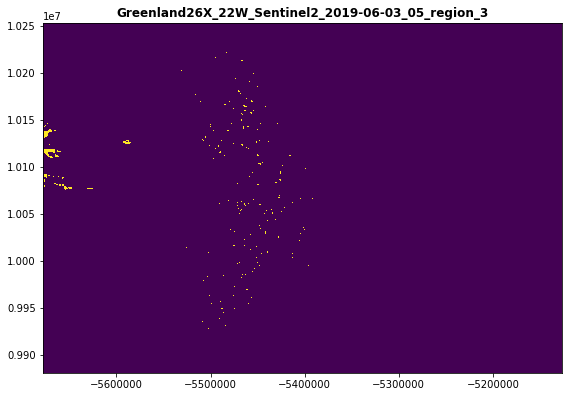

In [79]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Specify the path to the GeoTIFF file you want to plot
image_path =  "projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif" 

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Get the shape of the image
    shape = (src.height, src.width)

    # Create a Polygon geometry representing the extent of the image
    geom = gpd.GeoSeries([box(*src.bounds)], crs=src.crs)

    # Create a GeoDataFrame with the geometry
    tif_gdf = gpd.GeoDataFrame(geometry=geom)

    # Plot the raster content within the bounding box
    show(src, ax=ax, title="Greenland26X_22W_Sentinel2_2019-06-03_05_region_3", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

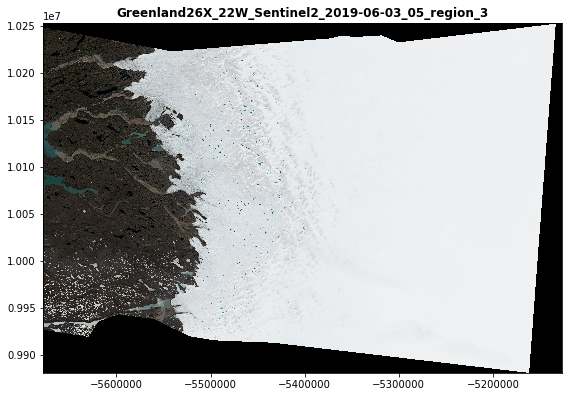

In [80]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Specify the path to the GeoTIFF file you want to plot
image_path =  "test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"  

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Get the shape of the image
    shape = (src.height, src.width)

    # Create a Polygon geometry representing the extent of the image
    geom = gpd.GeoSeries([box(*src.bounds)], crs=src.crs)

    # Create a GeoDataFrame with the geometry
    tif_gdf = gpd.GeoDataFrame(geometry=geom)

    # Plot the raster content within the bounding box
    show(src, ax=ax, title="Greenland26X_22W_Sentinel2_2019-06-03_05_region_3", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Sanity checks to plot randomly a part of a predicted test image and its corresponding part in the original test set.**

The paths to the original test folder and the projected predicted images must be set in the below cell.

resampled_image_path = "projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

test_image_path = "test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

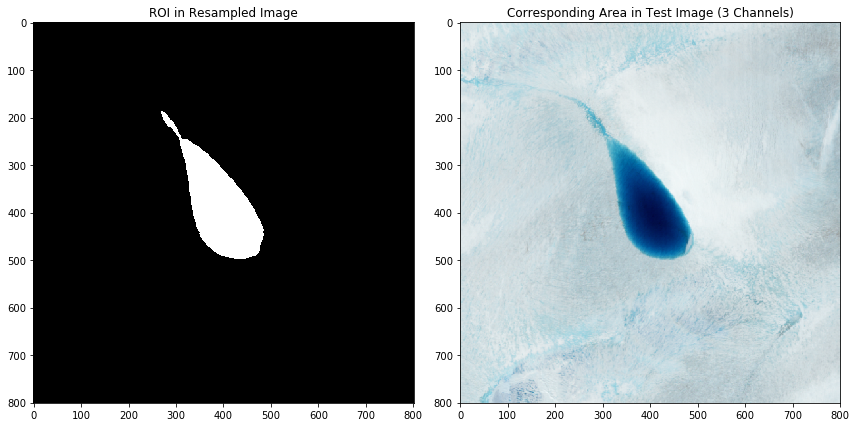

In [81]:
import rasterio
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the paths to the resampled image and test image
resampled_image_path = "projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"
test_image_path = "test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

# Seed the random number generator to ensure different results each time
random.seed()

# Open the resampled image
with rasterio.open(resampled_image_path) as resampled_src:
    # Read the resampled image as a numpy array
    resampled_image = resampled_src.read(1)

    # Find the coordinates of white pixels (pixel value == 255)
    white_pixel_coords = np.argwhere(resampled_image == 255)

    if white_pixel_coords.size == 0:
        print("No white pixels found in the resampled image.")
    else:
        # Randomly select one set of coordinates from the white pixels
        random_index = random.randint(0, white_pixel_coords.shape[0] - 1)
        y, x = white_pixel_coords[random_index]

        # Define the size of the smaller area
        area_size = 800

        # Calculate the coordinates for the smaller area
        min_y = max(y - area_size // 2, 0)
        max_y = min(y + area_size // 2, resampled_image.shape[0])
        min_x = max(x - area_size // 2, 0)
        max_x = min(x + area_size // 2, resampled_image.shape[1])

        # Extract the smaller area from the resampled image
        roi_resampled = resampled_image[min_y:max_y+1, min_x:max_x+1]

        # Open the test image with three channels (assuming it's a color image)
        with rasterio.open(test_image_path) as test_src:
            # Read the test image as a numpy array with three channels
            test_image = test_src.read([1, 2, 3])

            # Extract the corresponding area from the test image using the same coordinates
            roi_test = test_image[:, min_y:max_y+1, min_x:max_x+1]

        # Plot the ROI in both images for comparison
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(roi_resampled, cmap='gray')
        plt.title("ROI in Resampled Image")

        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(roi_test, (1, 2, 0)))  # Transpose the channels for correct display
        plt.title("Corresponding Area in Test Image (3 Channels)")

        plt.tight_layout()
        plt.show()

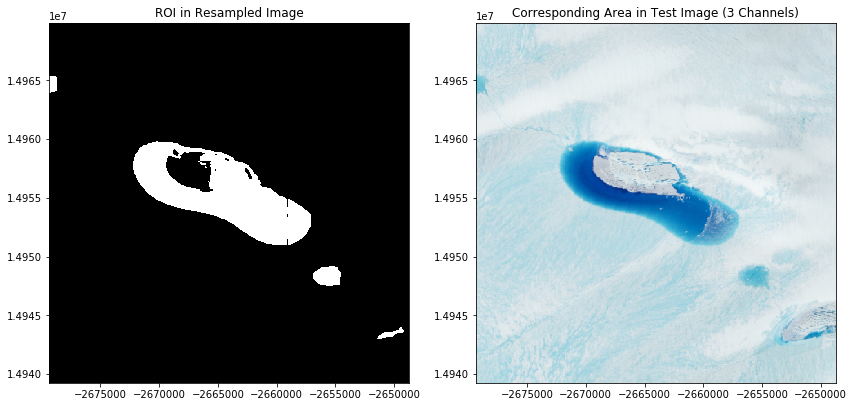

In [25]:
import rasterio.plot

# After extracting the ROI from the resampled image...
transform_resampled = resampled_src.transform
transform_test = test_src.transform

# Adjust the affine transform to account for the ROI
transform_resampled_roi = transform_resampled * rasterio.Affine.translation(min_x, min_y)
transform_test_roi = transform_test * rasterio.Affine.translation(min_x, min_y)

# Calculate extents for the images (left, right, bottom, top)
extent_resampled = rasterio.plot.plotting_extent(roi_resampled, transform_resampled_roi)
extent_test = rasterio.plot.plotting_extent(roi_test[0, :, :], transform_test_roi)  # Assuming all bands have the same extent

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(roi_resampled, cmap='gray', extent=extent_resampled)
plt.title("ROI in Resampled Image")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(roi_test, (1, 2, 0)), extent=extent_test)
plt.title("Corresponding Area in Test Image (3 Channels)")

plt.tight_layout()
plt.show()

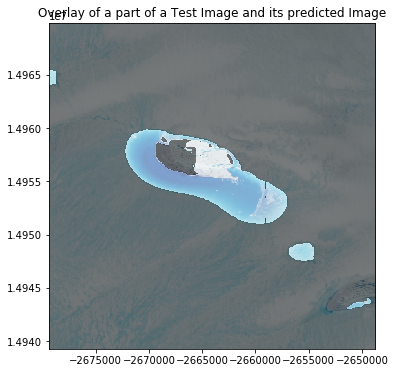

In [26]:
plt.figure(figsize=(12, 6))

# Display the test image as the base image
plt.imshow(np.transpose(roi_test, (1, 2, 0)), extent=extent_test)

# Overlay the resampled image with 10% transparency
plt.imshow(roi_resampled, cmap='gray', alpha=0.5, extent=extent_resampled)

plt.title("Overlay of a part of a Test Image and its predicted Image")
plt.show()

**End of the sanity checks**

**Part 6. Post processing and providing lake_polygons_test.gpkg**

Apply Solution Guidelines to filter predicted polygons by the model

**Sanity checks. You can skip running the code below.**

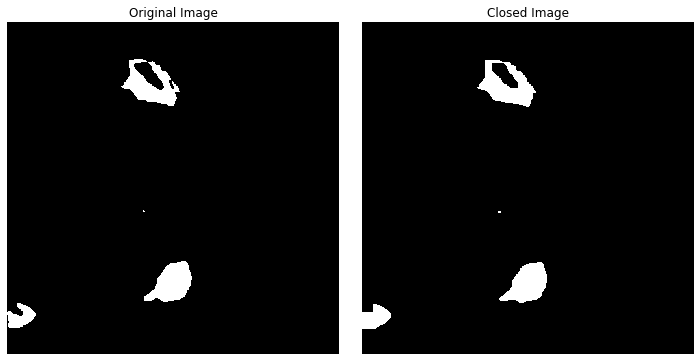

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [28]:
# Firstly check holes
# The below shows that there are some noises in the prediction. So, the code filled them.
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_closing(img_path, kernel_size=10):
    # Read the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Define the structuring element
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the closing operation
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return img, closed_img

# Path to your test image
test_image_path = "Final_Predictions/predicted_test_U_Net_no_overlap/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1_tile_012_006.tif"

original, closed = apply_closing(test_image_path)

# Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closed, cmap='gray')
plt.title('Closed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


# Test the function
image_path = "Final_Predictions/predicted_test_U_Net_no_overlap/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1_tile_012_006.tif"  # Replace with the path to your image
apply_closing(image_path, kernel_size=5)

**Fill noises in the predicted images.**

input_dir = "projected_predicted_images"

output_dir = "projected_predicted_images_closed

In [82]:
import cv2
import numpy as np
import os

import numpy as np
import os
import rasterio

def apply_closing_on_folder(input_dir, output_dir, kernel_size=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            with rasterio.open(input_path) as src:
                img = src.read(1)  
                metadata = src.meta 

                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

                # Now, write the closed image while preserving the metadata
                with rasterio.open(output_path, 'w', **metadata) as dst:
                    dst.write(closed_img, 1)


input_dir = "projected_predicted_images_submission_3"
output_dir = "projected_predicted_images_closed_submission_3"
apply_closing_on_folder(input_dir, output_dir)

The 3 cells below are sanity checks, there is no need to run them

No handles with labels found to put in legend.


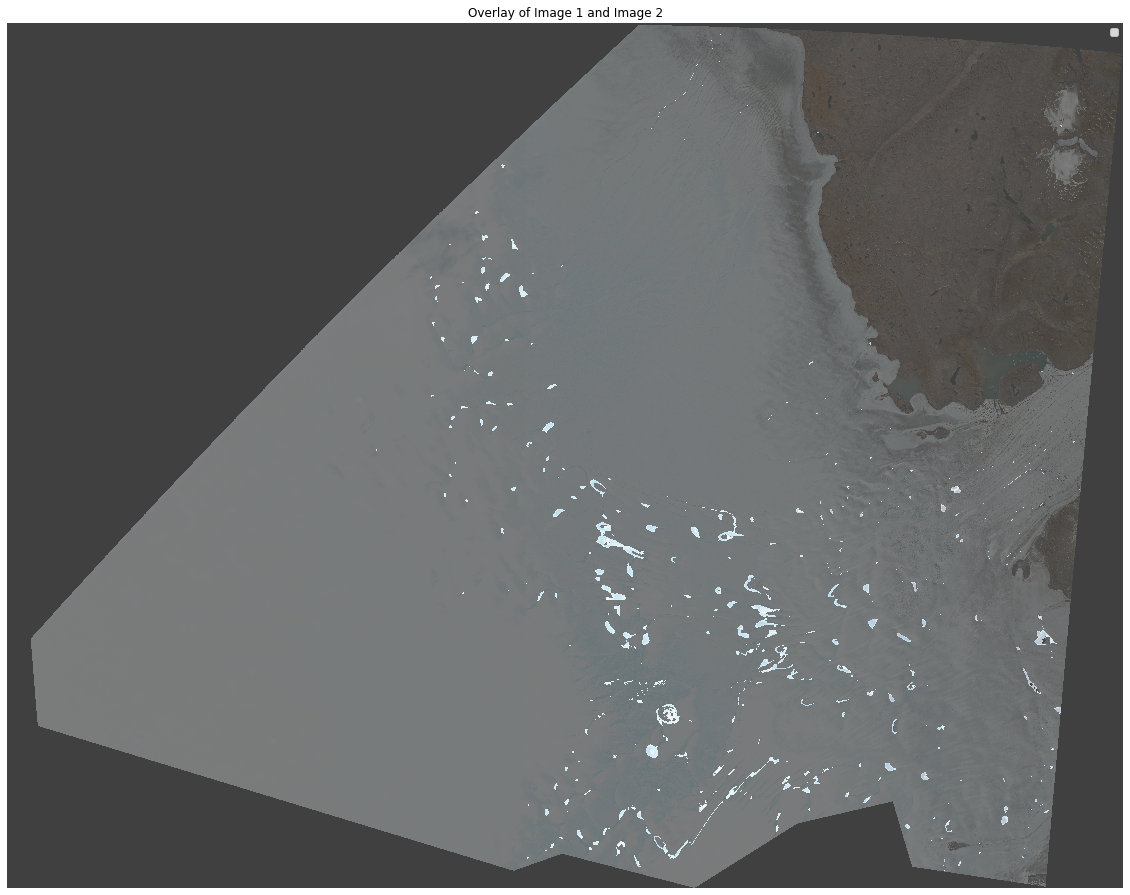

In [83]:
import matplotlib.pyplot as plt
import cv2

# Read the images
image1 = cv2.imread("/home/in18657@ad.umbc.edu/lake/test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif", cv2.IMREAD_COLOR)
image2 = cv2.imread( "projected_predicted_images_closed_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif", cv2.IMREAD_COLOR)

# Convert the images from BGR to RGB format
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Plot
plt.figure(figsize=(20,20))
plt.imshow(image1, alpha=0.5, label="Image 1") 
plt.imshow(image2, alpha=0.5, label="Image 2")  
plt.title('Overlay of Image 1 and Image 2')
plt.legend()
plt.axis('off')  # Hide axes
plt.show()

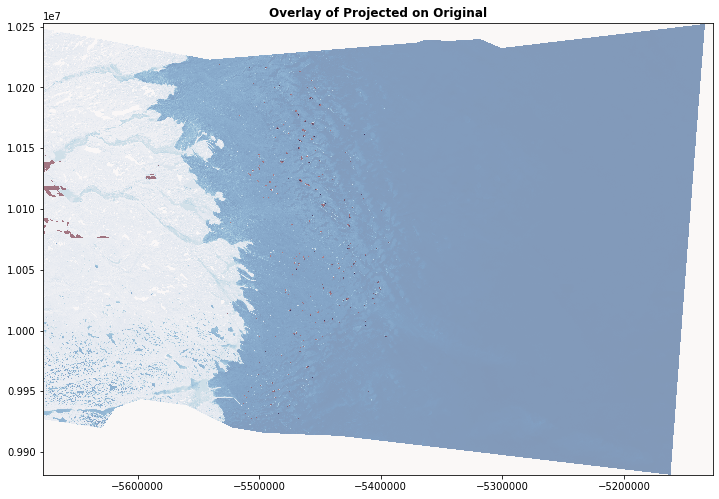

In [68]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Paths to the original and projected raster files
original_raster_path = "test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"
projected_raster_path = "projected_predicted_images_closed_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"

# Read the original raster
with rasterio.open(original_raster_path) as src:
    original_array = src.read(1)
    original_transform = src.transform

# Read the projected raster
with rasterio.open(projected_raster_path) as src:
    projected_array = src.read(1)
    projected_transform = src.transform

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Show the original raster (in blue)
show(original_array, transform=original_transform, ax=ax, cmap='Blues', title='Overlay of Projected on Original')
show(projected_array, transform=projected_transform, ax=ax, cmap='Reds', alpha=0.5)

plt.show()

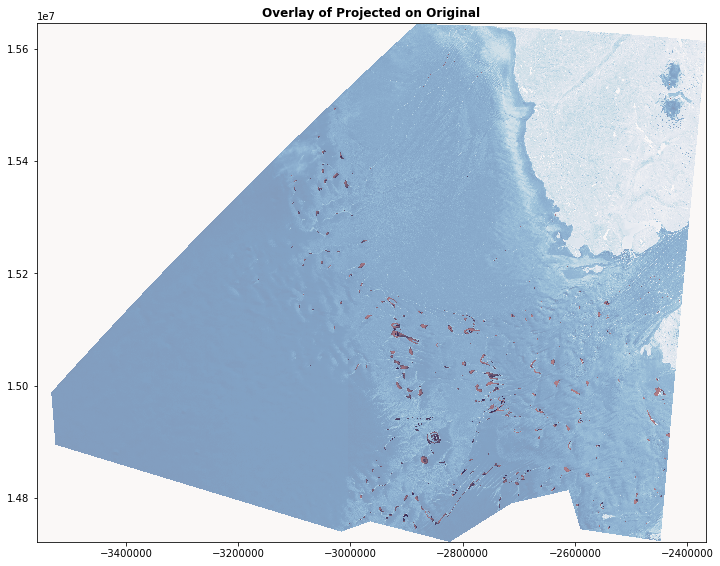

In [34]:
# overlay a predicted image after filling noises and an original test
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Paths to the original and projected raster files
original_raster_path = "test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"
projected_raster_path = "projected_predicted_images_closed_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

# Read the original raster
with rasterio.open(original_raster_path) as src:
    original_array = src.read(1)
    original_transform = src.transform

# Read the projected raster
with rasterio.open(projected_raster_path) as src:
    projected_array = src.read(1)
    projected_transform = src.transform

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Show the original raster (in blue)
show(original_array, transform=original_transform, ax=ax, cmap='Blues', title='Overlay of Projected on Original')
show(projected_array, transform=projected_transform, ax=ax, cmap='Reds', alpha=0.5)

plt.show()

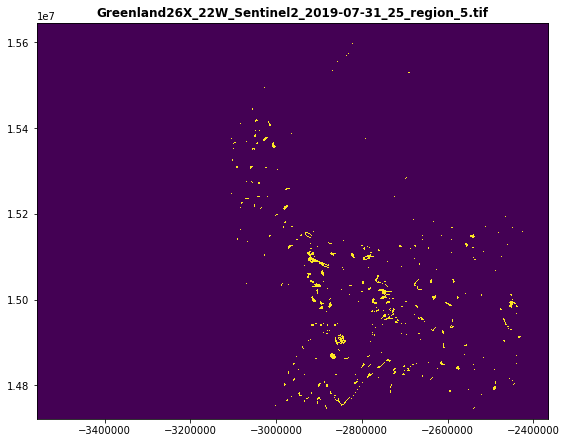

In [37]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Specify the path to the GeoTIFF file you want to plot
image_path =  "projected_predicted_images_closed_submission_3/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif" 

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Get the shape of the image
    shape = (src.height, src.width)

    # Create a Polygon geometry representing the extent of the image
    geom = gpd.GeoSeries([box(*src.bounds)], crs=src.crs)

    # Create a GeoDataFrame with the geometry
    tif_gdf = gpd.GeoDataFrame(geometry=geom)

    # Plot the raster content within the bounding box
    show(src, ax=ax, title="Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Provide the package with all solution guidelines**

A GeoPackage with your "answers" to the "test" regions should

be named “lake_polygons_test.gpkg”

have an identical column format to the “lake_polygons_training.gpkg” file, with each lake polygon specifying the image from which it was derived specified in the “image” column

be in the EPSG:3857 (“WGS 84 / Pseudo-Mercator”) coordinate reference system, the same as the input rasters and all provided GeoPackage files.

Below code create lake_polygons_test.gpkg.

The below path must be set:

test_prediction_dir = "projected_predicted_images"

Making "lake_polygons_test.gpkg" by the format of traing.gpkg. The training.gpkg contains 4 images contains 6 regions. Below cell create lake_polygons_test.gpkg with the stracture of traing.gpkg.

In [84]:
import os
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, Point
import re

# Function to validate lake shapes
def is_valid_lake(polygon):
    # Check if it's a simple polygon without any holes
    if not polygon.is_simple or len(polygon.interiors) > 0:
        return False

    # Compute the minimum bounding rectangle
    min_rect = polygon.minimum_rotated_rectangle
    # Extract the coordinates of the rectangle
    coords = list(min_rect.exterior.coords)
    
    # Compute the two sides of the rectangle
    side1 = Point(coords[0]).distance(Point(coords[1]))
    side2 = Point(coords[1]).distance(Point(coords[2]))
    
    # Get length and width of the rectangle
    length = max(side1, side2)
    width = min(side1, side2)
    
    # Check the length-to-width ratio
    if length / width > 10:
        return False
    return True

# Directory containing binary test prediction images
test_prediction_dir = "projected_predicted_images_closed_submission_3"

# Create an empty list to store test polygons
test_polygons = []

# Regular expression pattern to extract the file name and region number
pattern = r"(.*)_region_(\d+)\.tif"

# Iterate through each binary test prediction image
for filename in os.listdir(test_prediction_dir):
    if filename.endswith(".tif"):
        match = re.search(pattern, filename)
        if match:
            image_name = match.group(1)  # Extract the file name
            region_num = int(match.group(2))  # Extract the region number
        else:
            raise ValueError(f"Invalid filename format: {filename}")

        test_image_path = os.path.join(test_prediction_dir, filename)

        with rasterio.open(test_image_path) as src:
            if src.crs != "EPSG:3857":
                raise ValueError(f"CRS mismatch for {filename}. Expected EPSG:3857, but found {src.crs}")

            image_data = src.read(1)
            mask = (image_data == 255).astype('uint8')  # Assuming lakes are represented by 255

            for geometry, value in shapes(mask, transform=src.transform, mask=mask):
                if value == 1:  # Assuming the shapes function returns 1 for lakes
                    polygon_shape = shape(geometry)
                    if polygon_shape.area > 100000 and is_valid_lake(polygon_shape):
                        test_polygons.append({
                            "image": image_name,
                            "region_num": region_num,
                            "geometry": polygon_shape
                        })

print(f"Total number of test polygons: {len(test_polygons)}")

# Create a GeoDataFrame from the test polygons list
test_gdf = gpd.GeoDataFrame(test_polygons, geometry='geometry')

# Set the test GeoDataFrame's coordinate reference system (CRS)
test_gdf.crs = "EPSG:3857"

# Save the test GeoDataFrame to a GeoPackage file
output_test_gpkg = "lake_polygons_test.gpkg"
test_gdf.to_file(output_test_gpkg, driver="GPKG")

print(f"GeoPackage file '{output_test_gpkg}' for the test set created successfully.")

Total number of test polygons: 3137
GeoPackage file 'lake_polygons_test.gpkg' for the test set created successfully.


**Overlap check You can skip running the code below**

The below code identify and print out any image-region combinations where overlapping polygons exist

In [39]:
import geopandas as gpd


unique_image_regions = test_gdf[['image', 'region_num']].drop_duplicates().to_dict('records')

for entry in unique_image_regions:
    subset_gdf = test_gdf[(test_gdf['image'] == entry['image']) & (test_gdf['region_num'] == entry['region_num'])]

    # Check for overlaps: This will find polygons in subset_gdf that overlap with others in the same subset
    overlaps = gpd.sjoin(subset_gdf, subset_gdf, predicate='overlaps')

    if not overlaps.empty:
        print(f"Found overlaps in image {entry['image']} for region {entry['region_num']}.")

In [40]:
test_gdf = gpd.read_file("lake_polygons_test.gpkg")

polygon_counts = test_gdf.groupby(['image', 'region_num']).size().reset_index(name='num_polygons')

for _, row in polygon_counts.iterrows():
    print(f"Image: {row['image']}, Region: {row['region_num']}, Number of polygons: {row['num_polygons']}")

Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 1, Number of polygons: 199
Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 3, Number of polygons: 255
Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 5, Number of polygons: 23
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 2, Number of polygons: 510
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 4, Number of polygons: 486
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 6, Number of polygons: 383
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 1, Number of polygons: 220
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 3, Number of polygons: 160
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 5, Number of polygons: 559
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 2, Number of polygons: 41
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 4, Number of polygons: 54
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 6, Number of polygons:

**End part 6**

In [41]:
import os
import geopandas as gpd
import shutil

# Path to the test GeoPackage file
test_gpkg_path = "lake_polygons_test.gpkg"

# Directory to save the extracted images
output_folder = "extracted_test_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the test GeoDataFrame containing all test polygons
test_gdf = gpd.read_file(test_gpkg_path)

# Get unique image names from the test GeoDataFrame
unique_images = test_gdf["image"].unique()
print(unique_images)

# Iterate through each unique image and save it to the output folder
for image_name in unique_images:
    # Filter the GeoDataFrame for the current image
    image_gdf = test_gdf[test_gdf["image"] == image_name]

    # Get the unique region numbers for the current image
    unique_regions = image_gdf["region_num"].unique()
    print(unique_regions)

print(f"Test images saved to '{output_folder}' folder.")

['Greenland26X_22W_Sentinel2_2019-06-03_05'
 'Greenland26X_22W_Sentinel2_2019-08-25_29'
 'Greenland26X_22W_Sentinel2_2019-07-31_25'
 'Greenland26X_22W_Sentinel2_2019-06-19_20']
[3 1 5]
[6 2 4]
[5 1 3]
[6 4 2]
Test images saved to 'extracted_test_images' folder.


In [42]:
import geopandas as gpd

# Read the test GeoDataFrame containing all test polygons
test_gpkg = "lake_polygons_test.gpkg"
test_gdf = gpd.read_file(test_gpkg)

# Check the current CRS of the GeoDataFrame
print("Current CRS:", test_gdf.crs)

Current CRS: EPSG:3857


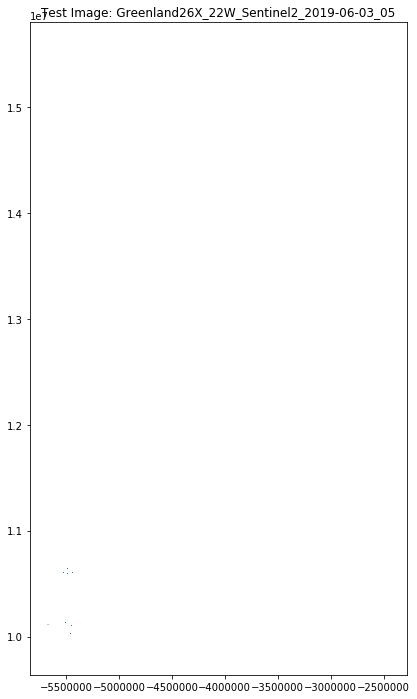

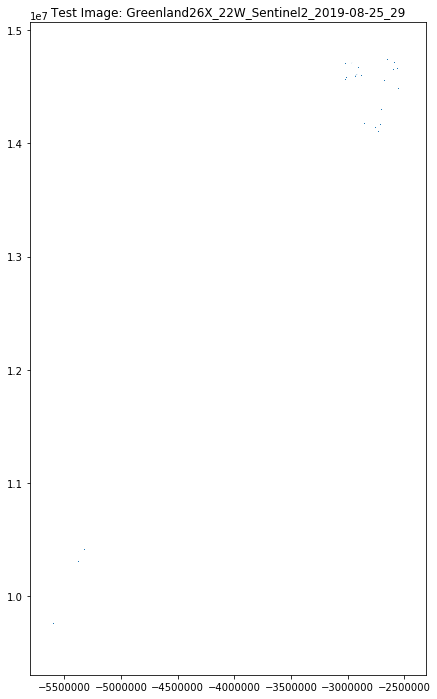

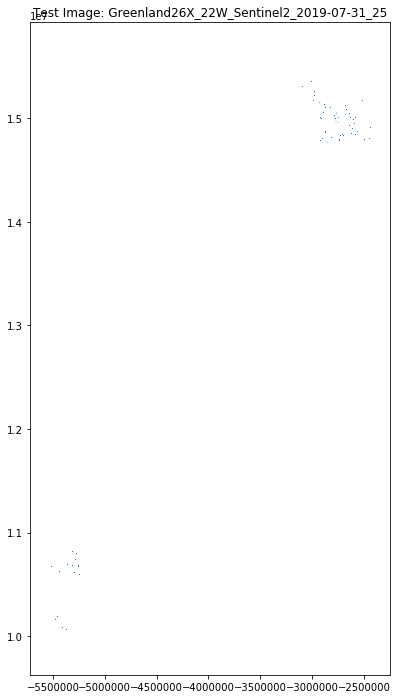

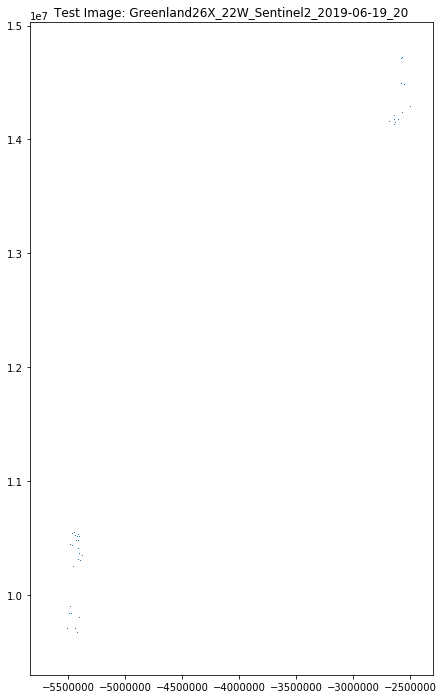

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the test GeoDataFrame containing all test polygons
test_gpkg = "lake_polygons_test.gpkg"
test_gdf = gpd.read_file(test_gpkg)

# Get unique image names from the test GeoDataFrame
unique_images = test_gdf["image"].unique()

# Create separate plots for each unique image
for image_name in unique_images:
    # Filter the GeoDataFrame for the current image
    image_gdf = test_gdf[test_gdf["image"] == image_name]

    # Plot the image
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f"Test Image: {image_name}")
    # Plot the polygons on top of the image
    image_gdf.plot(ax=ax)

    # Optionally, you can save each plot to a file
    plt.savefig(f"test_image_{image_name}.png")

    # Show the plot for the current image
    plt.show()

Extract 12 region from lake_polygons_test.gpkg" for a sanity check.

Overlay the extracted region with the projected images (Before and after making the test package)

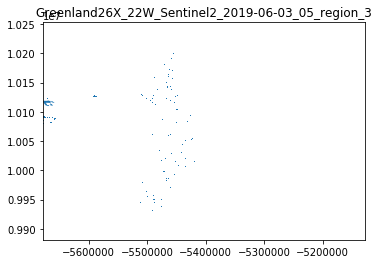

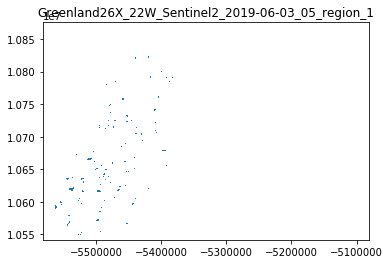

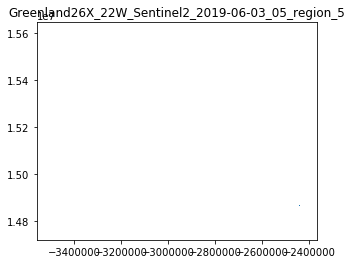

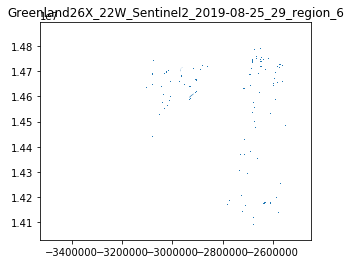

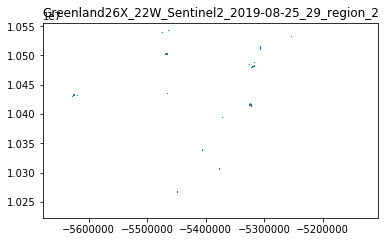

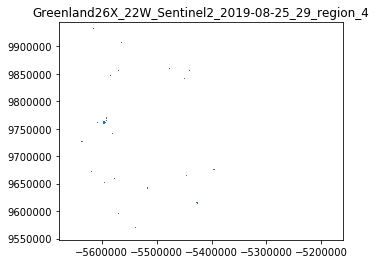

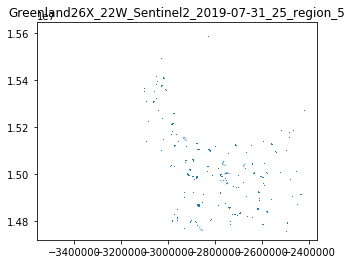

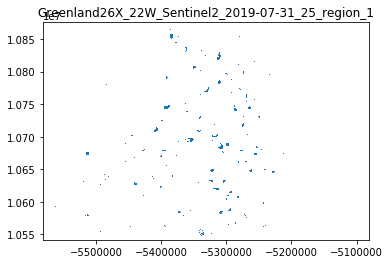

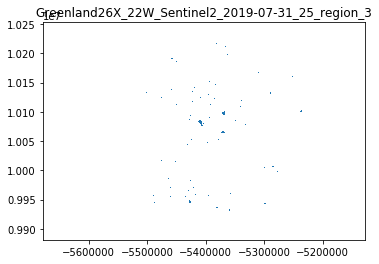

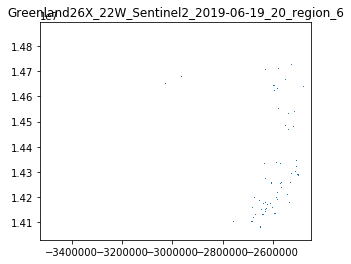

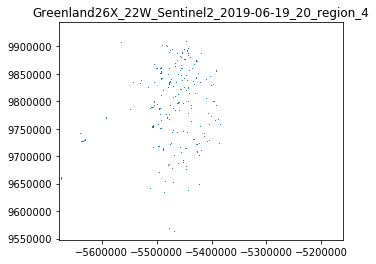

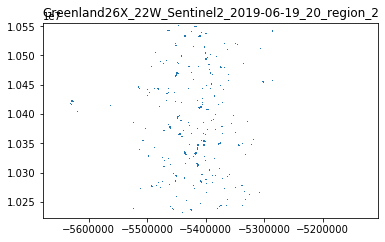

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

def plot_all_image_regions(gdf, raster_dir):
    # Loop through each unique image name
    for img_name in gdf['image'].unique():
        # For each image, loop through its unique regions
        for region in gdf[gdf['image'] == img_name]['region_num'].unique():
            filtered_gdf = gdf[(gdf['image'] == img_name) & (gdf['region_num'] == region)]
            
            if len(filtered_gdf) == 0:
                print(f"No polygons for {img_name} with region {region}")
                continue

            raster_path = os.path.join(raster_dir, f"{img_name}_region_{region}.tif")
            with rasterio.open(raster_path) as src:
                bounds = src.bounds

            fig, ax = plt.subplots()
            ax.set_xlim(bounds.left, bounds.right)
            ax.set_ylim(bounds.bottom, bounds.top)
            
            filtered_gdf.plot(ax=ax)
            plt.title(f"{img_name}_region_{region}")
            plt.show()

raster_directory = "projected_predicted_images"
gdf = gpd.read_file('lake_polygons_test.gpkg')
plot_all_image_regions(gdf, raster_directory)

Overlay an extracted region from lake_polygons_test.gpkg with its original test image, to see whether their coordinates are aligned (Before and after making the test package)overlay the extracted region with the projected images (Before and after making the test package)

/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/geopandas/plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


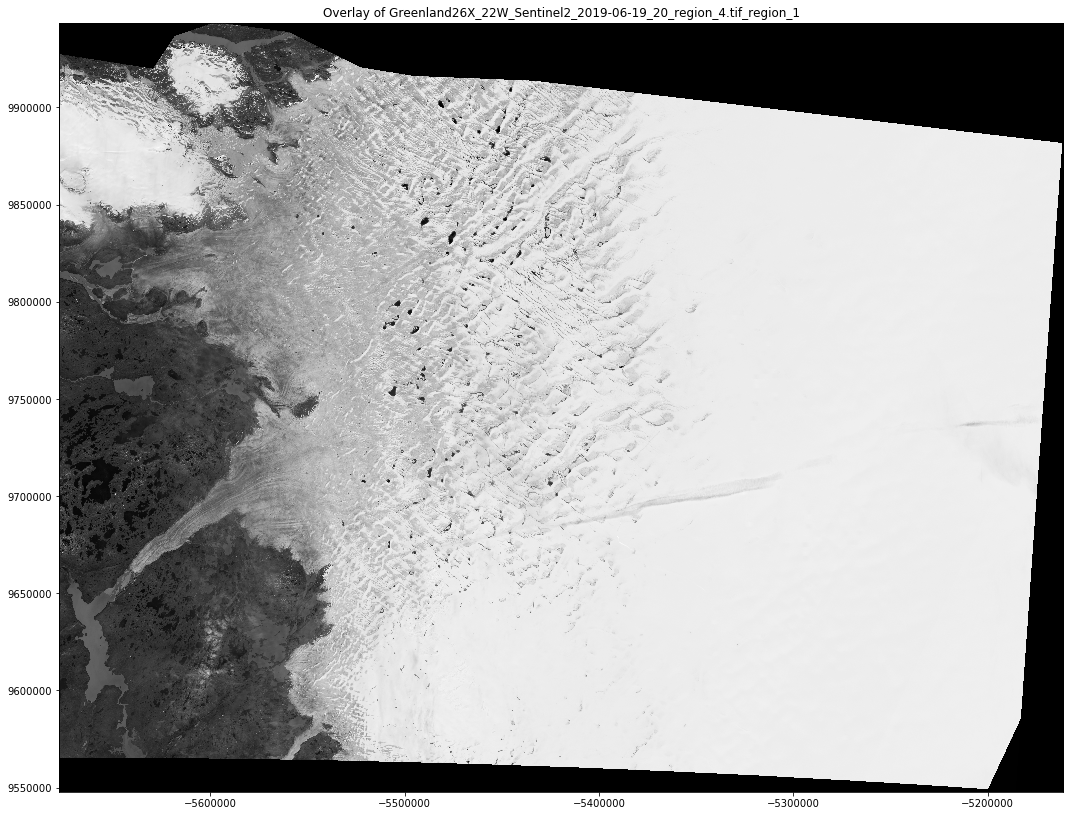

In [61]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# Define paths
projected_raster_path = "test/Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif"
geopackage_path = "lake_polygons_test.gpkg"


gdf = gpd.read_file(geopackage_path)

# Filtering the GeoDataFrame (You can skip this if you want to plot all polygons)
image_name = "Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif"
region_number = 1  # Assuming this is an integer in the dataset
filtered_gdf = gdf[(gdf['image'] == image_name) & (gdf['region_num'] == region_number)]

# Plotting
fig, ax = plt.subplots(figsize=(18,18))

# Plot the raster, converting white to black
with rasterio.open(projected_raster_path) as src:
    img_data = src.read(1)
    img_data[img_data == 255] = 0  # Convert white pixels to black
    show(img_data, ax=ax, transform=src.transform, cmap='gray')

# Overlay the polygons. Setting the boundary to be cyan and thicker for better visibility.
filtered_gdf.boundary.plot(ax=ax, color='cyan', linewidth=2.5)

plt.title(f"Overlay of {image_name}_region_{region_number}")
plt.show()
# Black Dots inside the Big Blue Dots: These are the predicted regions
#Big Blue Dots: These are the boundaries of the polygons

In [72]:
# sanity check
import rasterio

# Specify the path to the GeoTIFF file
image_path ="projected_predicted_images_submission_3/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"

try:
    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Check the metadata
        print("Image Metadata:")
        print(src.profile)

        # Read the image as a numpy array
        image = src.read()

    # Check if the image was successfully loaded
    if image is not None:
        print("Image loaded successfully.")
        print(f"Image shape: {image.shape}")
    else:
        print(f"Error loading image: {image_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Image Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 14414, 'height': 9723, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21851414258808, 0.0, -5678009.990621864,
       0.0, -38.21851414258808, 10252919.007546227), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Image loaded successfully.
Image shape: (1, 9723, 14414)


In [73]:
import rasterio

# Specify the path to the GeoTIFF file
image_path ="test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"

try:
    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Check the metadata
        print("Image Metadata:")
        print(src.profile)

        # Read the image as a numpy array
        image = src.read()

    # Check if the image was successfully loaded
    if image is not None:
        print("Image loaded successfully.")
        print(f"Image shape: {image.shape}")
    else:
        print(f"Error loading image: {image_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Image Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 14414, 'height': 9723, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21851414258808, 0.0, -5678009.990621864,
       0.0, -38.21851414258808, 10252919.007546227), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
Image loaded successfully.
Image shape: (3, 9723, 14414)


**End of sanity check**

**Part 7: Plotting the prediction of 12 test areas with their original images**

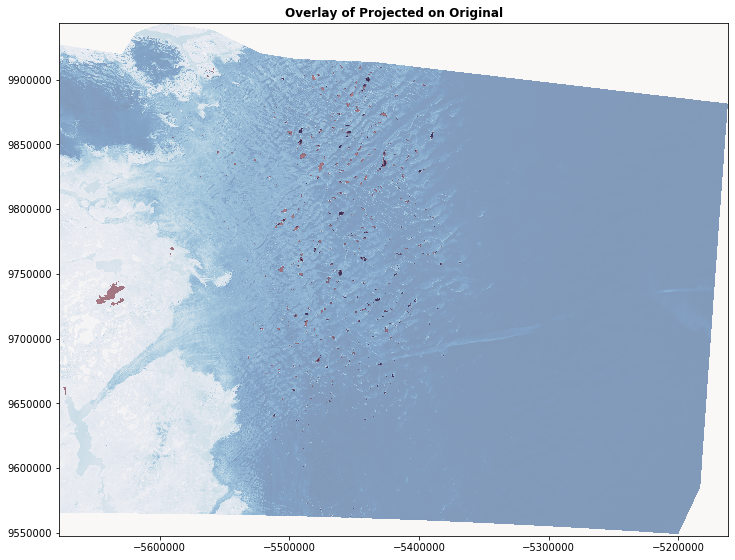

In [65]:
# overlay a prediction and an original test
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Paths to the original and projected raster files
original_raster_path = "test/Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif"
projected_raster_path = "projected_predicted_images_closed_submission_3/Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif"

# Read the original raster
with rasterio.open(original_raster_path) as src:
    original_array = src.read(1)
    original_transform = src.transform

# Read the projected raster
with rasterio.open(projected_raster_path) as src:
    projected_array = src.read(1)
    projected_transform = src.transform

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Show the original raster (in blue)
show(original_array, transform=original_transform, ax=ax, cmap='Blues', title='Overlay of Projected on Original')

# Overlay the projected raster (in red) with 50% transparency
show(projected_array, transform=projected_transform, ax=ax, cmap='Reds', alpha=0.5)

plt.show()

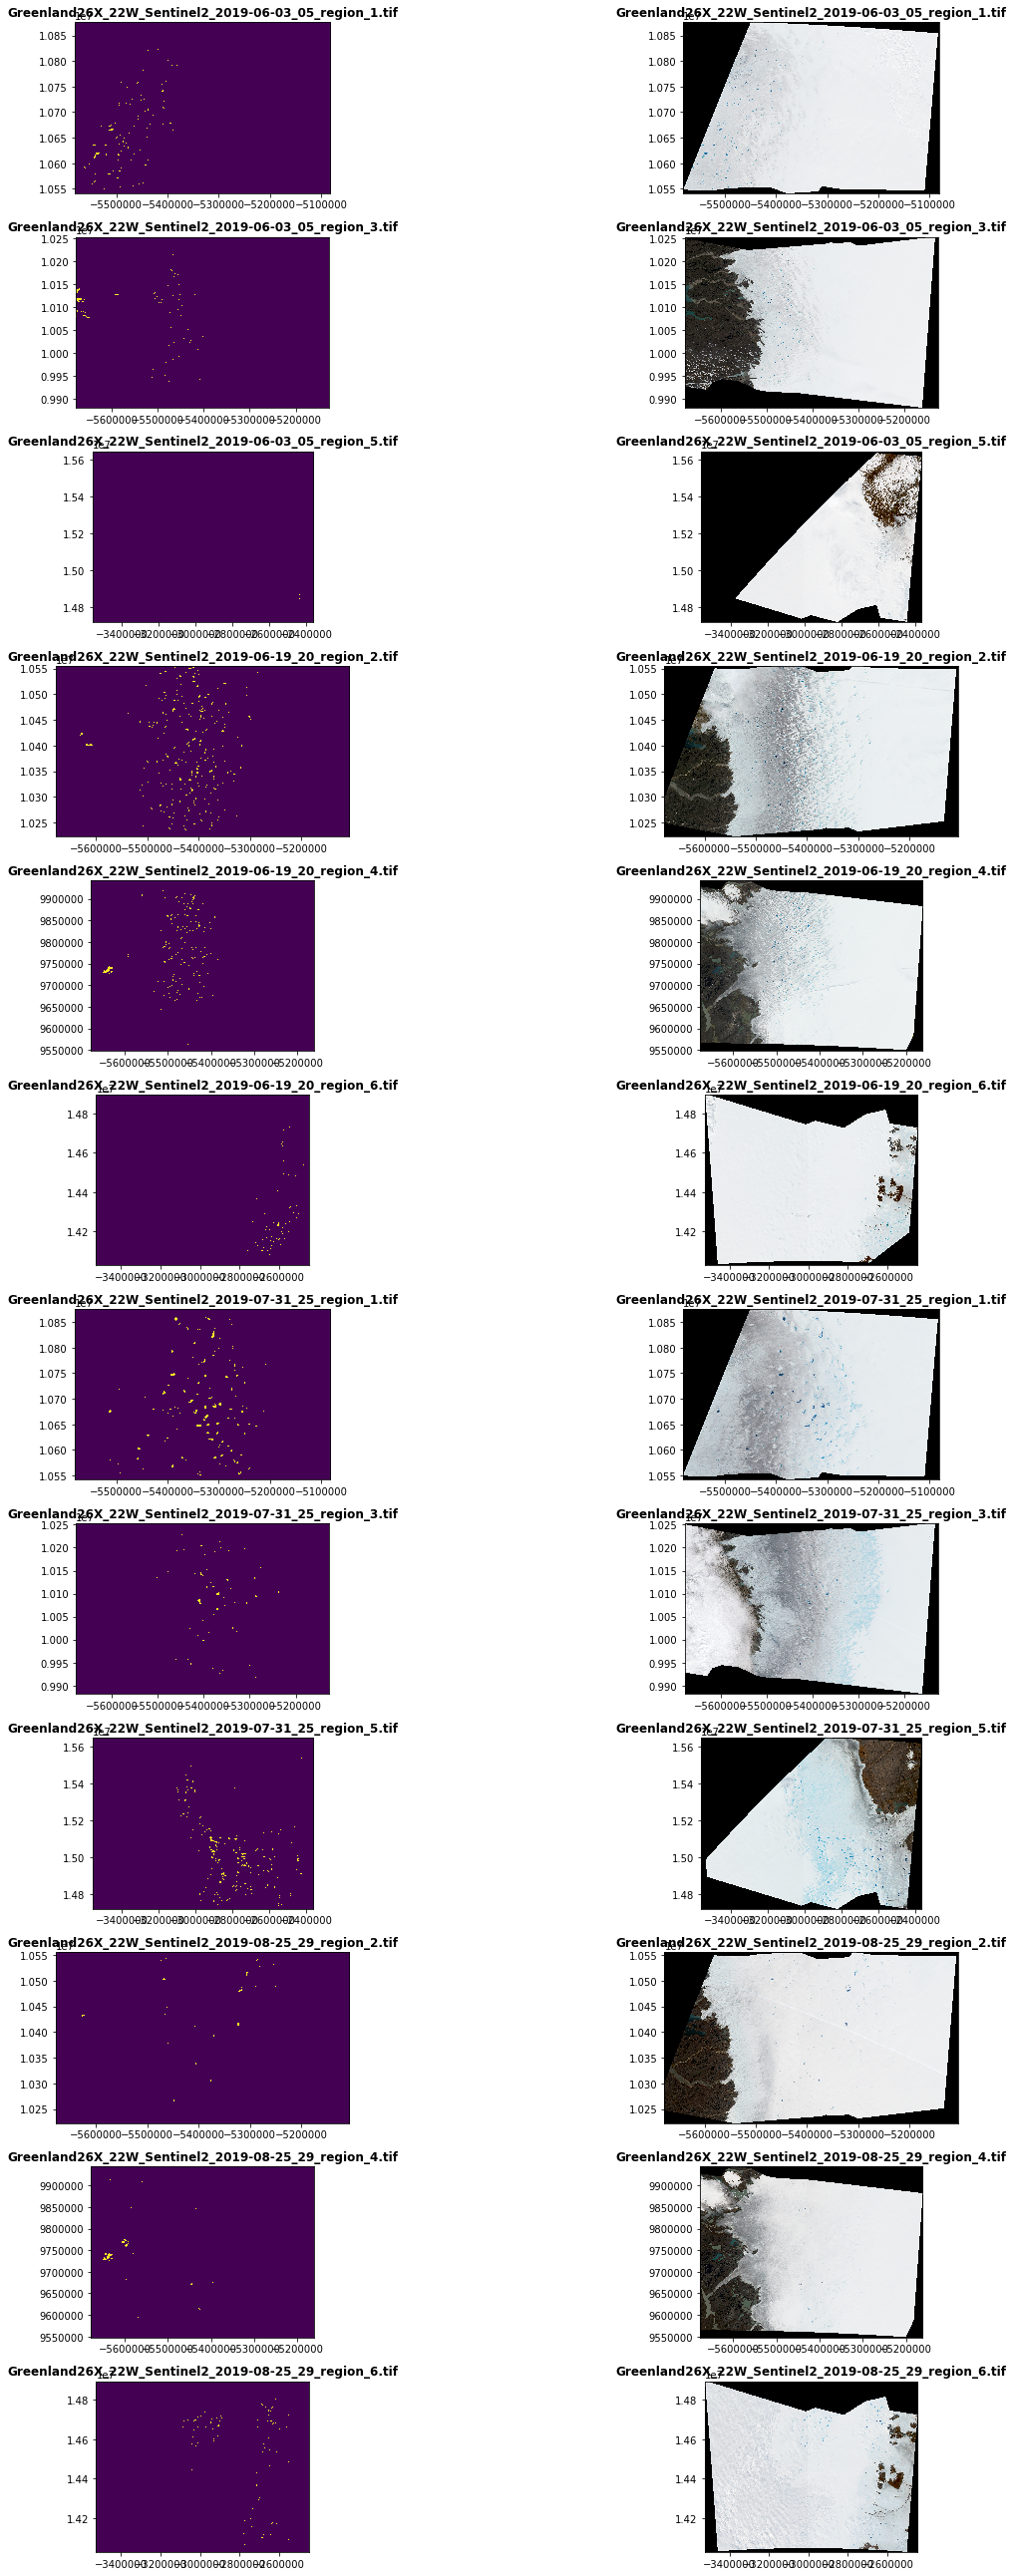

In [66]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Define the folder paths containing the test GeoTIFF files and their corresponding masks
image_folder_path = "projected_predicted_images_closed_submission_3"  # Image folder path
mask_folder_path = "test"  # Mask folder path

# List all the TIFF files in the images and mask directories
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(mask_folder_path) if f.endswith('.tif')]

# Sort the lists (to ensure pairs align correctly if they are named in an ordered fashion)
image_files.sort()
mask_files.sort()

# Assuming that each image has a corresponding mask
if len(image_files) != len(mask_files):
    raise ValueError("Number of images does not match number of masks!")

# Create a figure with a number of subplots equal to the number of images (and masks)
fig, axes = plt.subplots(len(image_files), 2, figsize=(18, 3 * len(image_files)))

for idx, (img_filename, mask_filename) in enumerate(zip(image_files, mask_files)):
    img_file = os.path.join(image_folder_path, img_filename)
    mask_file = os.path.join(mask_folder_path, mask_filename)
    
    with rasterio.open(img_file) as img_src, rasterio.open(mask_file) as mask_src:
        # Plot the raster content for the image with the image filename as title
        show(img_src, ax=axes[idx, 0], title=f"{img_filename}", cmap='viridis')
        
        # Plot the raster content for the mask with the mask filename as title
        show(mask_src, ax=axes[idx, 1], title=f"{mask_filename}", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [86]:
image_example = os.path.join(image_folder_path, image_files[0])
mask_example = os.path.join(mask_folder_path, mask_files[0])

with rasterio.open(image_example) as img_src, rasterio.open(mask_example) as mask_src:
    print("Image CRS:", img_src.crs)
    print("Image Bounds:", img_src.bounds)
    print("Mask CRS:", mask_src.crs)
    print("Mask Bounds:", mask_src.bounds)

Image CRS: EPSG:3857
Image Bounds: BoundingBox(left=-5581355.368355258, bottom=10541774.537435908, right=-5081533.640398491, top=10875536.82144313)
Mask CRS: EPSG:3857
Mask Bounds: BoundingBox(left=-5581355.368355258, bottom=10541774.537435908, right=-5081533.640398491, top=10875536.82144313)
